In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import joblib
import seaborn as sns
import anndata
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.1
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)

## Pairwise DMR

In [3]:
pairwise_dmr = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/InhDMR/PairwiseDMR.h5ad'
)

In [4]:
example_pair = ['MGE-Pvalb_Cacna1i', 'MGE-Sst_Rxra']

pair_id = pairwise_dmr.obs_names[
    pairwise_dmr.obs['cluster_a'].isin(example_pair)
    & pairwise_dmr.obs['cluster_b'].isin(example_pair)][0]
pair_id

'2465'

In [5]:
related_dmr = pairwise_dmr.var_names[pairwise_dmr.var_vector(pair_id).astype(bool)]

In [6]:
related_dmr

Index(['Subchr1_28', 'Subchr1_175', 'Subchr1_246', 'Subchr1_305',
       'Subchr1_321', 'Subchr1_343', 'Subchr1_446', 'Subchr1_500',
       'Subchr1_514', 'Subchr1_515',
       ...
       'SubchrY_3906', 'SubchrY_4096', 'SubchrY_4229', 'SubchrY_4249',
       'SubchrY_4251', 'SubchrY_4361', 'SubchrY_4376', 'SubchrY_4448',
       'SubchrY_5966', 'SubchrY_6035'],
      dtype='object', name='index', length=137696)

## DMR Rate

In [7]:
with pd.HDFStore('/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/DMRInfo.h5') as hdf:
    dmr_rate = hdf['Rate']

In [8]:
use_rate = dmr_rate.loc[related_dmr, example_pair].copy()
dmr_delta = (use_rate.iloc[:, 0] - use_rate.iloc[:, 1]).sort_values(ascending=False)
use_rate_up = use_rate.loc[dmr_delta[dmr_delta > 0.4].index]
use_rate_low = use_rate.loc[dmr_delta[dmr_delta < -0.4].index]

## DMR Motif Hit Score

In [9]:
dmr_annot = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/MotifScan.h5ad'
)
# no need to filter score here, use cnorm bellow
# motif_cutoff = pd.Series(dmr_annot.X.max(axis=0).todense().A1 * mask_quantile_to_max, index=dmr_annot.var_names)

dmr_annot = dmr_annot[related_dmr, :].copy()
dmr_annot

AnnData object with n_obs × n_vars = 137696 × 719 
    obs: 'chrom', 'start', 'end'

## Motif Enrichment

In [10]:
motif_gene_anno = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/MotifClustering/JASPAR2020_CORE_vertebrates_non-redundant.mouse_genes.with_motif_group.199.csv', 
    index_col=0
)
tf_class = pd.read_csv('/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv')
for tf_col in ['Class', 'Family', 'SubFamily']:
    gene_class_map = {}
    for _, (class_name, genes) in tf_class[[tf_col, 'EnsemblID']].iterrows():
        if isinstance(genes, float):
            continue
        for gene in genes.split(','):
            gene_class_map[gene] = class_name
    
    motif_gene_anno[tf_col] = motif_gene_anno['gene_ids'].apply(lambda i: gene_class_map.get(i.split('.')[0], ''))
motif_gene_anno.head()

,motif_name,motif_genes,gene_ids,gene_names,motif_group,Class,Family,SubFamily
motif_uid,,,,,,,,
MA0006.1,Ahr::Arnt,"Ahr,Arnt","ENSMUSG00000019256.17,ENSMUSG00000015522.18","Ahr,Arnt",MotifGroup178,Basic helix-loop-helix factors (bHLH),PAS,PAS-AHR
MA0854.1,Alx1,Alx1,ENSMUSG00000036602.14,Alx1,MotifGroup3,Homeo domain factors,Paired-related HD,ALX
MA0634.1,ALX3,ALX3,ENSMUSG00000014603.3,Alx3,MotifGroup3,Homeo domain factors,Paired-related HD,TPRX
MA0853.1,Alx4,Alx4,ENSMUSG00000040310.12,Alx4,MotifGroup3,Homeo domain factors,Paired-related HD,ALX
MA0007.3,Ar,Ar,ENSMUSG00000046532.8,Ar,MotifGroup32,Nuclear receptors with C4 zinc fingers,Steroid hormone receptors,GR-like(NR3C)


In [11]:
cluster_a, cluster_b = example_pair
motif_enrichment = pd.read_msgpack(
    f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/InhDMR/TEMP/{cluster_a}-{cluster_b}.msg'
)

motif_enrichment = pd.concat(
    [motif_gene_anno.reindex(motif_enrichment.index), motif_enrichment],
    axis=1)
motif_enrichment['log2odds'] = np.log2(motif_enrichment['oddsratio'])
motif_enrichment = motif_enrichment[(motif_enrichment['-lgp'] > 10) & (
    motif_enrichment['log2odds'].abs() > 1)].copy()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
motif_enrichment.sort_values('log2odds').iloc[:, :]

,motif_name,motif_genes,gene_ids,gene_names,motif_group,Class,Family,SubFamily,oddsratio,p_value,...,-lgp,left_hit,left_no_hit,right_hit,right_no_hit,left_hit_rate,right_hit_rate,ClusterA,ClusterB,log2odds
MA0142.1,Pou5f1::Sox2,"Pou5f1,Sox2","ENSMUSG00000024406.16,ENSMUSG00000074637.7","Pou5f1,Sox2",MotifGroup183,Homeo domain factors,POU,POU5,0.123747,7.115464e-54,...,52.177559,60.0,99940.0,182.0,37514.0,0.00060,0.004828,MGE-Pvalb_Cacna1i,MGE-Sst_Rxra,-3.014537
MA0698.1,ZBTB18,ZBTB18,ENSMUSG00000063659.11,Zbtb18,MotifGroup5,C2H2 zinc finger factors,More than 3 adjacent zinc fingers,ZNF238-like,0.238493,1.209785e-221,...,219.651628,810.0,99190.0,1248.0,36448.0,0.00810,0.033107,MGE-Pvalb_Cacna1i,MGE-Sst_Rxra,-2.067979
MA0784.1,POU1F1,POU1F1,ENSMUSG00000004842.18,Pou1f1,MotifGroup13,Homeo domain factors,POU,POU1,0.256940,1.261204e-43,...,42.001527,174.0,99826.0,254.0,37442.0,0.00174,0.006738,MGE-Pvalb_Cacna1i,MGE-Sst_Rxra,-1.960499
MA0787.1,POU3F2,POU3F2,ENSMUSG00000095139.2,Pou3f2,MotifGroup13,Homeo domain factors,POU,POU3,0.271689,1.408676e-199,...,197.596520,952.0,99048.0,1288.0,36408.0,0.00952,0.034168,MGE-Pvalb_Cacna1i,MGE-Sst_Rxra,-1.879971
MA0788.1,POU3F3,POU3F3,ENSMUSG00000045515.3,Pou3f3,MotifGroup13,Homeo domain factors,POU,POU3,0.276153,3.172993e-105,...,103.331998,507.0,99493.0,683.0,37013.0,0.00507,0.018119,MGE-Pvalb_Cacna1i,MGE-Sst_Rxra,-1.856463
MA0785.1,POU2F1,POU2F1,ENSMUSG00000026565.18,Pou2f1,MotifGroup13,Homeo domain factors,POU,POU2,0.283108,2.453662e-249,...,247.309759,1317.0,98683.0,1697.0,35999.0,0.01317,0.045018,MGE-Pvalb_Cacna1i,MGE-Sst_Rxra,-1.820576
MA0868.2,SOX8,SOX8,ENSMUSG00000024176.10,Sox8,MotifGroup59,High-mobility group (HMG) domain factors,SOX-related,Group E,0.288436,0.000000e+00,...,300.000000,2966.0,97034.0,3612.0,34084.0,0.02966,0.095819,MGE-Pvalb_Cacna1i,MGE-Sst_Rxra,-1.793675
MA0786.1,POU3F1,POU3F1,ENSMUSG00000090125.3,Pou3f1,MotifGroup13,Homeo domain factors,POU,POU3,0.290205,4.491315e-241,...,239.059099,1343.0,98657.0,1689.0,36007.0,0.01343,0.044806,MGE-Pvalb_Cacna1i,MGE-Sst_Rxra,-1.784854
MA0507.1,POU2F2,POU2F2,ENSMUSG00000008496.19,Pou2f2,MotifGroup13,Homeo domain factors,POU,POU2,0.294908,1.584491e-264,...,262.461895,1537.0,98463.0,1895.0,35801.0,0.01537,0.050271,MGE-Pvalb_Cacna1i,MGE-Sst_Rxra,-1.761662
MA0627.2,POU2F3,POU2F3,ENSMUSG00000032015.16,Pou2f3,MotifGroup13,Homeo domain factors,POU,POU2,0.295975,3.524520e-291,...,289.043329,1717.0,98283.0,2101.0,35595.0,0.01717,0.055735,MGE-Pvalb_Cacna1i,MGE-Sst_Rxra,-1.756453


In [16]:
def get_motif_score(motif_id):
    return pd.Series(dmr_annot.obs_vector(motif_id), index=dmr_annot.obs_names)

In [35]:
motif_ids = ['MA0868.2', 'MA1151.1']


In [36]:
motif_data = pd.DataFrame([get_motif_score(m) for m in motif_ids], index=motif_ids).T

In [37]:
motif_up = motif_data.loc[use_rate_up.index]
motif_low = motif_data.loc[use_rate_low.index]


In [38]:
motif_enrichment.loc[motif_ids, ['left_hit_rate', 'right_hit_rate']]

,left_hit_rate,right_hit_rate
MA0868.2,0.02966,0.095819
MA1151.1,0.09108,0.014643


In [39]:
(motif_up !=0).sum(axis=0)

MA0868.2    6837
MA1151.1    1974
dtype: int64

In [41]:
cutoff = 15
(motif_up['MA1151.1'] > cutoff).sum(), (motif_low['MA1151.1'] > cutoff).sum()

(6, 85)

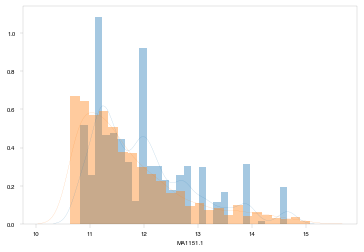

In [42]:
for name, col in motif_up.iteritems():
    sns.distplot(col[col>0], label=name)

## Plot

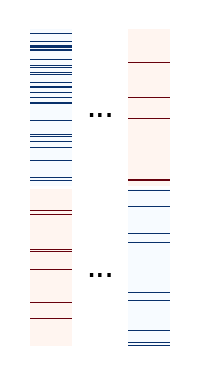

In [34]:
fig = plt.figure(figsize=(0.6, 1.5), dpi=300)

gs = fig.add_gridspec(15, 3)

i = 0
motif_id = motif_ids[0]
ax_up = fig.add_subplot(gs[0:7, i])
ax_low = fig.add_subplot(gs[7:14, i])

ax = ax_up
ax.imshow(motif_up.loc[:, motif_id].values[:, None],
          aspect='auto',
          cmap='Blues',
          vmin=8,
          vmax=10)
ax.axis('off')
ax = ax_low
ax.imshow(motif_low.loc[:, motif_id].values[:, None],
          aspect='auto',
          cmap='Reds',
          vmin=8,
          vmax=10)
ax.axis('off')

i = 1
ax_up = fig.add_subplot(gs[0:7, i])
ax_up.text(0.5, 0.5, '...', fontsize=8, ha='center', va='center')
ax_low = fig.add_subplot(gs[7:14, i])
ax_low.text(0.5, 0.5, '...', fontsize=8, ha='center', va='center')
ax_up.axis('off')
ax_low.axis('off')



i = 2
motif_id = motif_ids[1]
ax_up = fig.add_subplot(gs[0:7, i])
ax_low = fig.add_subplot(gs[7:14, i])

ax = ax_up
ax.imshow(motif_up.loc[:, motif_id].values[:, None],
          aspect='auto',
          cmap='Reds',
          vmin=12.9,
          vmax=13)
ax.axis('off')
ax = ax_low
ax.imshow(motif_low.loc[:, motif_id].values[:, None],
          aspect='auto',
          cmap='Blues',
          vmin=12.9,
          vmax=13)
ax.axis('off')

fig.savefig('PairwiseDMR.inh.motif_example.pdf')

In [55]:
from ALLCools.motif.utilities import *

In [88]:
motif_dict = meme_to_pfm_dict(
    '/home/hanliu/ref/MEME/selected_motifs_sets/JASPAR2020_CORE_vertebrates_non-redundant_pfms.meme',
    bits_scale=True)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ALLCools/motif/utilities.py:138: RuntimeWarning: divide by zero encountered in log2
  information_content = (pfm * np.log2(pfm / 0.25)).sum(axis=1)


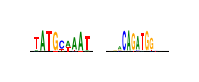

In [91]:
fig, axes = plt.subplots(figsize=(0.6, 0.1), ncols=2, dpi=300)

for motif_id, ax in zip(motif_ids, axes.flat):
    pfm = motif_dict[motif_id]
    plot_pfm(pfm, ax=ax, logo_kws=None)
    ax.axis('off')
fig.savefig('MotifLogo.inh.pdf')


In [100]:
motif_gene_anno.loc[motif_ids]

,motif_name,motif_genes,gene_ids,gene_names,motif_group,Class,Family,SubFamily
motif_uid,,,,,,,,
MA0789.1,POU3F4,POU3F4,ENSMUSG00000056854.4,Pou3f4,MotifGroup13,Homeo domain factors,POU,POU3
MA1109.1,NEUROD1,NEUROD1,ENSMUSG00000034701.9,Neurod1,MotifGroup5,Basic helix-loop-helix factors (bHLH),Tal-related,Neurogenin-ATO
